# ДЗ №3. Ансамбли (50 баллов)

В этом домашнем задании нужно реализовать алгоритм Random Forest и реализовать методы ансамблирования Stacking и Blending. 

## Данные

Вы будете работать с [датасетом Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/data).
* Если у вас нет возможности зарегестрироваться на Kaggle, то данные лежат [тут](https://drive.google.com/file/d/16SJ4FeqMIsfzqpbcm82Yl8F6MU7MODr9/view?usp=drive_link).

* _Если вы используете данные с диска, то сами сформируйте train/val/test выборку_


Предобработайте данные как мы делали в папке [Работа с признаками](https://github.com/runnerup96/SBT-machine-learning-seminars/tree/main/Работа%20с%20признаками) - заполните пропущенные данные, обработайте редкие значения, закодируйте категориальные признаки, создайте и отберите признаки.

## 1 Preliminaries

## 1.1 Imports and Configurations

In [1]:
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from tqdm import tqdm
from pathlib import Path
from ydata_profiling import ProfileReport
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from PIL import Image
from IPython.display import display

### Constants

In [3]:
# 1 Preliminaries

RANDOM_STATE = 42

TRAIN_PATH = Path('../data/raw/train.csv')
TEST_PATH = Path('../data/raw/test.csv')
REPORTS_DIR = Path('../reports/')
REPORTS_DIR.mkdir(exist_ok=True)
SUBMISSIONS_PATH = Path('../data/final/')

FEATURES_WITH_NUM_NA = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
FEATURES_WITH_CAT_NA = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
FEATURE_OUTLIER_THRESHOLDS = {
    'RoomService': {'upper': 3000},
    'FoodCourt': {'upper': 5000},
    'ShoppingMall': {'upper': 4000},
    'Spa': {'upper': 5000},
    'VRDeck': {'upper': 5000},
}
FEATURES_CAT = ['PassengerId', 'missingindicator_Name', 'missingindicator_Age', 
                'missingindicator_RoomService', 'missingindicator_FoodCourt', 'missingindicator_ShoppingMall', 
                'missingindicator_Spa', 'missingindicator_VRDeck', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 
                'VIP', 'Name', 'missingindicator_HomePlanet', 'missingindicator_CryoSleep', 'missingindicator_Cabin',
                'missingindicator_Destination', 'missingindicator_VIP', 'missingindicator_Name']

# 2 Feature Utility Scores

FEATURE_TARGET = 'Transported'
MI_SCORES_THRESHOLD = 0.001

## 3 Feature Engineering

FEATURES_NEW_TO_DEL = ['PassengerId', 'Cabin', 'Name']

### Configs

In [4]:
warnings.filterwarnings('ignore')

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

REPORTS_DIR.mkdir(exist_ok=True)

## 1.2 Data Preprocessing

### Read

In [5]:
def read_data(path):
    return pd.read_csv(path)

In [6]:
df = read_data(TRAIN_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Profile Report

In [7]:
profile_report = ProfileReport(df, title='Profile Report')

In [8]:
profile_report.to_file(REPORTS_DIR.joinpath('eda_report.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Clean

In [9]:
def clean(df):
    df[['CryoSleep', 'VIP']] = \
        df[['CryoSleep', 'VIP']].astype('Int64').astype('string')
    return df

In [10]:
df_cleaned = clean(df)
df_cleaned.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Missing Values

In [11]:
def impute(df, knn_imputer, features_with_num_na, features_with_cat_na):
    
    def impute_num(df, knn_imputer, features_with_num_na):
        X = df[features_with_num_na].copy()
        X = pd.DataFrame(knn_imputer.transform(X))
        X.columns = knn_imputer.get_feature_names_out()
        X[['missingindicator_Age', 'missingindicator_RoomService', 'missingindicator_ShoppingMall', 
           'missingindicator_Spa', 'missingindicator_VRDeck']] = \
            X[['missingindicator_Age', 'missingindicator_RoomService', 'missingindicator_ShoppingMall', 
           'missingindicator_Spa', 'missingindicator_VRDeck']].astype('Int64').astype('string')
        X = df.drop(columns=features_with_num_na).join(X)
        return X
    
    def impute_cat(df, features_with_cat_na):
        X = df[features_with_cat_na].copy()
        
        for feature in features_with_cat_na:
            X['missingindicator_' + feature] = X[feature].isna().astype('Int64').astype('string')
            X[X[feature].isna()] = 'Missing'

        X = df.drop(columns=features_with_cat_na).join(X)
        return X

    df = impute_num(df, knn_imputer, features_with_num_na)
    df = impute_cat(df, features_with_cat_na)
    
    return df

In [12]:
knn_imputer = KNNImputer(add_indicator=True).fit(df_cleaned[FEATURES_WITH_NUM_NA])
df_imputed = impute(df_cleaned, knn_imputer, FEATURES_WITH_NUM_NA, FEATURES_WITH_CAT_NA)
df_imputed.head()

,PassengerId,Transported,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,missingindicator_Age,missingindicator_RoomService,...,Cabin,Destination,VIP,Name,missingindicator_HomePlanet,missingindicator_CryoSleep,missingindicator_Cabin,missingindicator_Destination,missingindicator_VIP,missingindicator_Name
0,0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,0,0,...,B/0/P,TRAPPIST-1e,0,Maham Ofracculy,0,0,0,0,0,0
1,0002_01,True,24.0,109.0,9.0,25.0,549.0,44.0,0,0,...,F/0/S,TRAPPIST-1e,0,Juanna Vines,0,0,0,0,0,0
2,0003_01,False,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0,...,A/0/S,TRAPPIST-1e,1,Altark Susent,0,0,0,0,0,0
3,0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,A/0/S,TRAPPIST-1e,0,Solam Susent,0,0,0,0,0,0
4,0004_01,True,16.0,303.0,70.0,151.0,565.0,2.0,0,0,...,F/1/S,TRAPPIST-1e,0,Willy Santantines,0,0,0,0,0,0


In [13]:
df_imputed.isna().sum().sum()

0

### Outliers

In [14]:
def windorize_outliers(df, feature_outlier_thresholds):
    
    for feature, thresholds in feature_outlier_thresholds.items():
        if 'upper' in thresholds.keys():
            df.loc[df[feature] > thresholds['upper'], feature] = thresholds['upper']
        elif 'lower' in thresholds.keys():
            df.loc[df[feature] < thresholds['lower'], feature] = thresholds['lower']

    return df

In [15]:
df_without_outliers = windorize_outliers(df_imputed, FEATURE_OUTLIER_THRESHOLDS)
df_without_outliers.head()

,PassengerId,Transported,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,missingindicator_Age,missingindicator_RoomService,...,Cabin,Destination,VIP,Name,missingindicator_HomePlanet,missingindicator_CryoSleep,missingindicator_Cabin,missingindicator_Destination,missingindicator_VIP,missingindicator_Name
0,0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,0,0,...,B/0/P,TRAPPIST-1e,0,Maham Ofracculy,0,0,0,0,0,0
1,0002_01,True,24.0,109.0,9.0,25.0,549.0,44.0,0,0,...,F/0/S,TRAPPIST-1e,0,Juanna Vines,0,0,0,0,0,0
2,0003_01,False,58.0,43.0,3576.0,0.0,5000.0,49.0,0,0,...,A/0/S,TRAPPIST-1e,1,Altark Susent,0,0,0,0,0,0
3,0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,A/0/S,TRAPPIST-1e,0,Solam Susent,0,0,0,0,0,0
4,0004_01,True,16.0,303.0,70.0,151.0,565.0,2.0,0,0,...,F/1/S,TRAPPIST-1e,0,Willy Santantines,0,0,0,0,0,0


### Encode

In [16]:
def encode(df, features_cat):
    
    def encode_cat(df, features_cat):
        for feature in features_cat:
            df[feature] = df[feature].astype('category')
        return df
    
    df = encode_cat(df, features_cat)
    return df

In [17]:
df_encoded = encode(df_without_outliers, FEATURES_CAT)
df_encoded.head()

,PassengerId,Transported,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,missingindicator_Age,missingindicator_RoomService,...,Cabin,Destination,VIP,Name,missingindicator_HomePlanet,missingindicator_CryoSleep,missingindicator_Cabin,missingindicator_Destination,missingindicator_VIP,missingindicator_Name
0,0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,0,0,...,B/0/P,TRAPPIST-1e,0,Maham Ofracculy,0,0,0,0,0,0
1,0002_01,True,24.0,109.0,9.0,25.0,549.0,44.0,0,0,...,F/0/S,TRAPPIST-1e,0,Juanna Vines,0,0,0,0,0,0
2,0003_01,False,58.0,43.0,3576.0,0.0,5000.0,49.0,0,0,...,A/0/S,TRAPPIST-1e,1,Altark Susent,0,0,0,0,0,0
3,0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,A/0/S,TRAPPIST-1e,0,Solam Susent,0,0,0,0,0,0
4,0004_01,True,16.0,303.0,70.0,151.0,565.0,2.0,0,0,...,F/1/S,TRAPPIST-1e,0,Willy Santantines,0,0,0,0,0,0


In [18]:
df_encoded.dtypes

PassengerId                      category
Transported                          bool
Age                               float64
RoomService                       float64
FoodCourt                         float64
ShoppingMall                      float64
Spa                               float64
VRDeck                            float64
missingindicator_Age             category
missingindicator_RoomService     category
missingindicator_FoodCourt       category
missingindicator_ShoppingMall    category
missingindicator_Spa             category
missingindicator_VRDeck          category
HomePlanet                       category
CryoSleep                        category
Cabin                            category
Destination                      category
VIP                              category
Name                             category
missingindicator_HomePlanet      category
missingindicator_CryoSleep       category
missingindicator_Cabin           category
missingindicator_Destination     c

### Summary

In [19]:
def load_data(path, features_with_num_na, features_with_cat_na, 
              feature_outlier_thresholds, features_cat):
    df = read_data(path)
    df = clean(df)
    knn_imputer = KNNImputer(add_indicator=True).fit(df[features_with_num_na])
    df = impute(df, knn_imputer, features_with_num_na, features_with_cat_na)
    df = windorize_outliers(df, feature_outlier_thresholds)
    df = encode(df, features_cat)
    return df

In [20]:
df = load_data(
    TRAIN_PATH, 
    FEATURES_WITH_NUM_NA, 
    FEATURES_WITH_CAT_NA,
    FEATURE_OUTLIER_THRESHOLDS,
    FEATURES_CAT,
)
df.head()

,PassengerId,Transported,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,missingindicator_Age,missingindicator_RoomService,...,Cabin,Destination,VIP,Name,missingindicator_HomePlanet,missingindicator_CryoSleep,missingindicator_Cabin,missingindicator_Destination,missingindicator_VIP,missingindicator_Name
0,0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,0,0,...,B/0/P,TRAPPIST-1e,0,Maham Ofracculy,0,0,0,0,0,0
1,0002_01,True,24.0,109.0,9.0,25.0,549.0,44.0,0,0,...,F/0/S,TRAPPIST-1e,0,Juanna Vines,0,0,0,0,0,0
2,0003_01,False,58.0,43.0,3576.0,0.0,5000.0,49.0,0,0,...,A/0/S,TRAPPIST-1e,1,Altark Susent,0,0,0,0,0,0
3,0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,A/0/S,TRAPPIST-1e,0,Solam Susent,0,0,0,0,0,0
4,0004_01,True,16.0,303.0,70.0,151.0,565.0,2.0,0,0,...,F/1/S,TRAPPIST-1e,0,Willy Santantines,0,0,0,0,0,0


In [21]:
df.isna().sum().sum()

0

In [22]:
df.dtypes

PassengerId                      category
Transported                          bool
Age                               float64
RoomService                       float64
FoodCourt                         float64
ShoppingMall                      float64
Spa                               float64
VRDeck                            float64
missingindicator_Age             category
missingindicator_RoomService     category
missingindicator_FoodCourt       category
missingindicator_ShoppingMall    category
missingindicator_Spa             category
missingindicator_VRDeck          category
HomePlanet                       category
CryoSleep                        category
Cabin                            category
Destination                      category
VIP                              category
Name                             category
missingindicator_HomePlanet      category
missingindicator_CryoSleep       category
missingindicator_Cabin           category
missingindicator_Destination     c

## 2 Feature Utility Scores

## 2.1 MI Scores

In [23]:
def make_mi_scores(X, y, features_bad=None, random_state=0):
    if features_bad is None:
        features_bad = []
    
    X = X.drop(columns=features_bad).copy()
    for feature in X.select_dtypes(['object', 'category']):
        X[feature], _ = X[feature].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [24]:
mi_scores = make_mi_scores(df, df[FEATURE_TARGET], features_bad=['PassengerId', FEATURE_TARGET], 
                           random_state=RANDOM_STATE)
mi_scores

Cabin                            1.295505
CryoSleep                        0.108798
Spa                              0.086079
RoomService                      0.073887
VRDeck                           0.065624
ShoppingMall                     0.060049
FoodCourt                        0.036294
Name                             0.027768
HomePlanet                       0.027604
Age                              0.016546
Destination                      0.013313
VIP                              0.010201
missingindicator_HomePlanet      0.008994
missingindicator_CryoSleep       0.006976
missingindicator_Cabin           0.004571
missingindicator_Destination     0.003218
missingindicator_VRDeck          0.002063
missingindicator_Name            0.001168
missingindicator_VIP             0.001138
missingindicator_Spa             0.000839
missingindicator_RoomService     0.000647
missingindicator_FoodCourt       0.000085
missingindicator_ShoppingMall    0.000000
missingindicator_Age             0

## 2.2 Drop Uninformative

In [25]:
def drop_uninformative(df, mi_scores, threshold, features_bad=None):
    if features_bad is None:
        features_bad = []
    features_to_del = features_bad
    
    X = df.drop(columns=features_to_del)
    X = X.loc[:, mi_scores > threshold]
    return X.join(df[features_bad])

In [26]:
df_informative = drop_uninformative(df, mi_scores, MI_SCORES_THRESHOLD, features_bad=['PassengerId', FEATURE_TARGET])
df_informative.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'missingindicator_VRDeck', 'HomePlanet', 'CryoSleep', 'Cabin',
       'Destination', 'VIP', 'Name', 'missingindicator_HomePlanet',
       'missingindicator_CryoSleep', 'missingindicator_Cabin',
       'missingindicator_Destination', 'missingindicator_VIP',
       'missingindicator_Name', 'PassengerId', 'Transported'],
      dtype='object')

## 3 Feature Engineering

## 3.1 Create Features with Pandas

In [27]:
def math_transforms(df):
    X = pd.DataFrame()
    X['Amount'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + \
        df['Spa'] + df['VRDeck']
    return X

In [28]:
def extractions(df):
    X = pd.DataFrame()

    X['GroupNumer'] = df['PassengerId'].str.slice(0, 4).astype('category')
    X['PassengerNumber'] = df['PassengerId'].str.slice(-2).astype('category')
    X['CabinFirstLetter'] = df['Cabin'].str.slice(0, 1).astype('category')
    X['CabinLastLetter'] = df['Cabin'].str.slice(-1, -2, -1).astype('category')
    return X

## 3.2 Create Final Dataset

In [29]:
def create_features(df, feature_target, mi_threshold, features_new_to_del, random_state=0):
    X = df.copy()
    X = X.join(math_transforms(X))
    X = X.join(extractions(X))
    X = X.drop(columns=['PassengerId', 'Cabin', 'Name'])
    
    return X

In [30]:
mi_scores = make_mi_scores(df.drop(columns=FEATURE_TARGET), df[FEATURE_TARGET], 
                               features_bad=['PassengerId'], random_state=RANDOM_STATE)
df_new = drop_uninformative(df, mi_scores, MI_SCORES_THRESHOLD, features_bad=['PassengerId', FEATURE_TARGET])

df_new = create_features(
    df_new, 
    FEATURE_TARGET, 
    MI_SCORES_THRESHOLD,
    FEATURES_NEW_TO_DEL,
    random_state=RANDOM_STATE,
)

mi_scores_new = make_mi_scores(df_new, df_new[FEATURE_TARGET], random_state=RANDOM_STATE)
df_new = drop_uninformative(df_new, mi_scores_new, MI_SCORES_THRESHOLD)

In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Age                           8693 non-null   float64 
 1   RoomService                   8693 non-null   float64 
 2   FoodCourt                     8693 non-null   float64 
 3   ShoppingMall                  8693 non-null   float64 
 4   Spa                           8693 non-null   float64 
 5   VRDeck                        8693 non-null   float64 
 6   missingindicator_VRDeck       8693 non-null   category
 7   HomePlanet                    8693 non-null   category
 8   CryoSleep                     8693 non-null   category
 9   Destination                   8693 non-null   category
 10  VIP                           8693 non-null   category
 11  missingindicator_HomePlanet   8693 non-null   category
 12  missingindicator_CryoSleep    8693 non-null   ca

## 3.3 Feature Engineering Report

In [32]:
profiling_report = ProfileReport(df_new, title='Feature Engineering Profile Report')

In [33]:
profiling_report.to_file(REPORTS_DIR.joinpath('feature_engineering_report.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.4 Preprocessing Pipeline

In [34]:
def get_preprocessor(df, feature_target):
    df = df.drop(columns=feature_target)
    features_num = list(df.select_dtypes(('int64', 'float64')).columns)
    features_cat_target = [feature for feature in df.select_dtypes('category').columns \
                           if len(df[feature].value_counts()) > 20]
    features_cat_onehot = [feature for feature in df.select_dtypes('category').columns \
                           if feature not in features_cat_target]
    assert len(features_num) + len(features_cat_target) + len(features_cat_onehot) == df.shape[1]
    
    num_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('transformer', QuantileTransformer()),
    ])

    cat_target_transformer = Pipeline([
        ('target_encoder', TargetEncoder()),
    ])

    cat_onehot_transformer = Pipeline([
        ('onehot_encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ])
    
    preprocessor = ColumnTransformer([
        ('num', num_transformer, features_num),
        ('cat_target', cat_target_transformer, features_cat_target),
        ('cat_onehot', cat_onehot_transformer, features_cat_onehot),
    ])
    return preprocessor

In [35]:
preprocessor = get_preprocessor(df_new, FEATURE_TARGET)

In [36]:
X = pd.DataFrame(preprocessor.fit_transform(df_new.drop(columns=FEATURE_TARGET), df_new[FEATURE_TARGET]))
X.columns = preprocessor.get_feature_names_out()
y = df_new[FEATURE_TARGET].astype('Int64')

In [37]:
X.head()

,num__Age,num__RoomService,num__FoodCourt,num__ShoppingMall,num__Spa,num__VRDeck,num__Amount,cat_target__GroupNumer,cat_onehot__missingindicator_VRDeck_1,cat_onehot__HomePlanet_Europa,...,cat_onehot__CabinFirstLetter_B,cat_onehot__CabinFirstLetter_C,cat_onehot__CabinFirstLetter_D,cat_onehot__CabinFirstLetter_E,cat_onehot__CabinFirstLetter_F,cat_onehot__CabinFirstLetter_G,cat_onehot__CabinFirstLetter_M,cat_onehot__CabinFirstLetter_T,cat_onehot__CabinLastLetter_S,cat_onehot__CabinLastLetter_g
0,0.777277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503666,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.404905,0.776026,0.688188,0.744745,0.866597,0.746747,0.504505,0.503595,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.963964,0.744745,0.963805,0.000000,1.000000,0.749899,0.988067,0.503595,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.652152,0.000000,0.912844,0.863613,0.976992,0.809810,0.939809,0.503595,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.151151,0.824424,0.745735,0.816817,0.869870,0.665165,0.686987,0.503666,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [38]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: Int64

## 3.5 Train-test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6519, 35), (2174, 35), (6519,), (2174,))

## Задание №1 Random Forest (20 баллов)

Реализуйте __RandomForest__ алгоритм. В качестве базового алгоритма возьмите [DecisionTreeСlassifer](https://scikit-learn.org/stable/modules1/generated/sklearn.tree.DecisionTreeClassifier.html) из sklearn.

* Сравните качество с [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) из sklearn на датасете SpaceShipTitanic. Различие должно быть не более **5%** по метрике **Accuracy**.

* Подберите гиперпараметры для вашего алгоритма с помощью __Optuna__ (пример с семинара [тут](https://github.com/runnerup96/SBT-machine-learning-seminars/blob/main/Деревья%20и%20ансамбли/Деревья%20решений%20и%20ансамбли.ipynb)) и продемонстрируйте качество на тестовой выборке.

**Если вы смогли участвовать в Kaggle соревновании, приложите скриншот в ноутбук вашего сабмита с этим алгоритмом**

In [40]:
class RandomForest:
    def __init__(
        self, 
        n_estimators=100, 
        criterion='gini', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True, 
    ):
        self.n_estimators = n_estimators
        self.criterion = criterion 
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.estimators = [
            DecisionTreeClassifier(
                criterion=criterion, 
                max_depth=max_depth,
                min_samples_split=min_samples_split, 
                min_samples_leaf=min_samples_leaf
            ) for _ in range(n_estimators)
        ]

    @staticmethod
    def __str__():
        return f'My Random Forest()'

    def __get_bootstraped_X(self, X, y, n, f):
        if self.bootstrap:
            row_choices = np.random.choice(X.index, size=n)
        else:
            row_choices = X.index
        
        if self.max_features == 'sqrt':
            col_choices = np.random.choice(X.columns, size=round(np.sqrt(f)), replace=False)
        elif self.max_features == 'log2':
            col_choices = np.random.choice(X.columns, size=round(np.log2(f)), replace=False)
        else:
            col_choices = X.columns
            
        return X.loc[row_choices, col_choices], y.loc[row_choices]
    
    def fit(self, X, y):
        n, f = X.shape

        for estimator in self.estimators:
            X_boostrapped, y_boostrapped = self.__get_bootstraped_X(X, y, n, f)
            estimator.fit(X_boostrapped, y_boostrapped)
    
    def predict_proba(self, X):
        preds = []
        for estimator in self.estimators:
            preds.append(estimator.predict_proba(X[estimator.feature_names_in_]))
        return np.array(preds).mean(axis=0)

    def predict(self, X):
        preds = self.predict_proba(X)
        
        return np.array(np.argmax(preds, axis=1))

    def get_params(self, deep=False):
        return {
            'n_estimators': self.n_estimators, 
            'criterion': self.criterion, 
            'max_depth': self.max_depth, 
            'min_samples_split': self.min_samples_split, 
            'min_samples_leaf': self.min_samples_leaf, 
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
        }

In [41]:
my_random_forest = RandomForest()
sklearn_random_forest = RandomForestClassifier(random_state=RANDOM_STATE)

my_random_forest_cv = cross_val_score(my_random_forest, X_train, y_train, cv=5, scoring='f1')
sklearn_random_cv = cross_val_score(sklearn_random_forest, X_train, y_train, cv=5, scoring='f1')

print(f'Cross-val f1 of my model: {my_random_forest_cv.mean():.4f}')
print(f'Cross-val f1 of sklearn model: {sklearn_random_cv.mean():.4f}')

Cross-val f1 of my model: 0.7546
Cross-val f1 of sklearn model: 0.7692


In [42]:
def my_rf_objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 10, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    clf = RandomForest(
        **param, 
    )
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = f1_score(y_test, preds)
    return accuracy

In [43]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
rf_study = optuna.create_study(sampler=sampler, study_name='my_random_forest', direction='maximize')
rf_study.optimize(my_rf_objective, n_trials=15)

[I 2023-12-10 16:59:50,802] A new study created in memory with name: my_random_forest
[I 2023-12-10 16:59:54,349] Trial 0 finished with value: 0.7479596735477677 and parameters: {'n_estimators': 381, 'criterion': 'gini', 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.7479596735477677.
[I 2023-12-10 17:00:00,253] Trial 1 finished with value: 0.7489072365225838 and parameters: {'n_estimators': 834, 'criterion': 'gini', 'max_depth': 68, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.7489072365225838.
[I 2023-12-10 17:00:13,125] Trial 2 finished with value: 0.8012968967114404 and parameters: {'n_estimators': 461, 'criterion': 'gini', 'max_depth': 123, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.8012968967114404.
[I 2023-12-10 17:00:16,158] Trial 3 fi

In [44]:
my_random_forest = RandomForest(**rf_study.best_params)
sklearn_random_forest = RandomForestClassifier()

my_random_forest.fit(X_train, y_train)
sklearn_random_forest.fit(X_train, y_train)

print(f'My test sample f1: {f1_score(y_test, my_random_forest.predict(X_test)):.4f}')
print(f'Sklearn test sample f1: {f1_score(y_test, sklearn_random_forest.predict(X_test)):.4f}')

My test sample f1: 0.8015
Sklearn test sample f1: 0.7766


### Submission

In [51]:
df_test = load_data(TEST_PATH, FEATURES_WITH_NUM_NA, FEATURES_WITH_CAT_NA, FEATURE_OUTLIER_THRESHOLDS, FEATURES_CAT)
df_test.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,missingindicator_Age,missingindicator_RoomService,missingindicator_FoodCourt,...,Cabin,Destination,VIP,Name,missingindicator_HomePlanet,missingindicator_CryoSleep,missingindicator_Cabin,missingindicator_Destination,missingindicator_VIP,missingindicator_Name
0,0013_01,27.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,G/3/S,TRAPPIST-1e,0,Nelly Carsoning,0,0,0,0,0,0
1,0018_01,19.0,0.0,9.0,0.0,2823.0,0.0,0,0,0.0,...,F/4/S,TRAPPIST-1e,0,Lerome Peckers,0,0,0,0,0,0
2,0019_01,31.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,C/0/S,55 Cancri e,0,Sabih Unhearfus,0,0,0,0,0,0
3,0021_01,38.0,0.0,5000.0,0.0,181.0,585.0,0,0,0.0,...,C/1/S,TRAPPIST-1e,0,Meratz Caltilter,0,0,0,0,0,0
4,0023_01,20.0,10.0,0.0,635.0,0.0,0.0,0,0,0.0,...,F/5/S,TRAPPIST-1e,0,Brence Harperez,0,0,0,0,0,0


In [52]:
df_test_new = drop_uninformative(df_test, mi_scores, MI_SCORES_THRESHOLD, features_bad=['PassengerId'])

df_test_new = create_features(
    df_test_new, 
    FEATURE_TARGET, 
    MI_SCORES_THRESHOLD,
    FEATURES_NEW_TO_DEL,
    random_state=RANDOM_STATE,
)

df_test_new = drop_uninformative(df_test_new, mi_scores_new, MI_SCORES_THRESHOLD)

In [53]:
X_submission = pd.DataFrame(preprocessor.transform(df_test_new))
X_submission.columns = preprocessor.get_feature_names_out()

In [54]:
submission_1 = pd.DataFrame({
    'PassengerID': df_test['PassengerId'], 
    'Transported': my_random_forest.predict(X_submission).astype('bool')})

In [55]:
submission_1.to_csv(SUBMISSIONS_PATH.joinpath('submission_1.csv'), index=False)

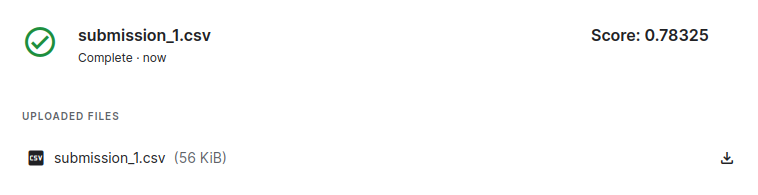

In [56]:
img_submission_1 = Image.open(REPORTS_DIR.joinpath('submission_1.png'))
display(img_submission_1)

## Задание №2 Stacking (15 баллов)

Реализуйте стекинг(методом, представленном на лекции) над 3-5 алгоритмами (сами алгоритмы реализовывать не надо, брать готовые реализации). Продемонстрируйте качество вашей реализации: покажите метрики базовых моделей и ансамбля на тестовой выборке. Если в качестве метамодели вы используете логрег, выведите веса признаков каждой модели. Подбор гиперпараметров для ваших алгоритмов на ваше усмотрение. 

**Если вы смогли участвовать в Kaggle соревновании, приложите скриншот вашего сабмита с этим алгоритмом**

In [57]:
class Stacking:
    def __init__(self, estimators, final_estimator, n_splits=5, test_size=0.25, random_state=None):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.n_splits = n_splits
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        estimator_preds = np.zeros((X.shape[0], len(self.estimators)))
        skf = StratifiedKFold(n_splits=self.n_splits, random_state=self.random_state)

        for i, estimator in enumerate(estimators):
            for train_idxs, test_idxs in skf.split(X, y):
                estimator.fit(X.iloc[train_idxs], y.iloc[train_idxs])
                estimator_preds[test_idxs, i] = estimator.predict_proba(X.iloc[test_idxs])[:, 0]

        self.final_estimator.fit(estimator_preds, y)

    def __predict_proba_estimators(self, X):
        preds = []
        for estimator in self.estimators:
            preds.append(estimator.predict_proba(X))
        return np.array(preds)[:, :, 0].T

    def predict_proba(self, X):
        estimator_preds = self.__predict_proba_estimators(X)
        return self.final_estimator.predict_proba(estimator_preds)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        return np.argmax(preds, axis=1)

    def get_params(self, deep=False):
        return {
            'estimators': self.estimators, 
            'final_estimator': self.final_estimator,
        }

In [58]:
estimators = [
    XGBClassifier(),
    LogisticRegression(),
    MultinomialNB(),
    SVC(kernel='poly', probability=True),
    SVC(kernel='rbf', probability=True),
    RandomForest(**rf_study.best_params),
    RandomForestClassifier(),
]

In [59]:
for estimator in tqdm(estimators):
    estimator.fit(X_train, y_train)

for estimator in estimators:
    print(f'{str(estimator)} test sample f1: {f1_score(y_test, estimator.predict(X_test)):.4f}')

100%|█████████████████████████████████████████████| 7/7 [00:42<00:00,  6.12s/it]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) test sample f1: 0.8036
LogisticRegression() test sample f1: 0.7561
MultinomialNB() test sample f1: 0.7160
SVC(kernel='poly', probability=True) test sample f1: 0.7771
SVC(probability=True) test sample f1: 0.7545
My Random Forest() test sample 

In [60]:
my_stacking = Stacking(estimators, LogisticRegression(max_iter=1000))
my_stacking.fit(X, y)

print(f'My stacking test sample f1: {f1_score(y_test, my_stacking.predict(X_test)):.4f}')

My stacking test sample f1: 0.8682


In [61]:
print('Meta-model coeffs:\n')
for algorthm, coef in zip(estimators, my_stacking.final_estimator.coef_[0]):
    print(f'{str(algorthm)}: {coef}')

Meta-model coeffs:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...): -1.496772120964836
LogisticRegression(): -0.7458161891449306
MultinomialNB(): 0.3261396194726994
SVC(kernel='poly', probability=True): -1.3751959765397783
SVC(probability=True): 0.574824013332085
My Random Forest(): -3.11

### Submission

In [62]:
submission_2 = pd.DataFrame({
    'PassengerID': df_test['PassengerId'], 
    'Transported': my_stacking.predict(X_submission).astype('bool')})

In [63]:
submission_2.to_csv(SUBMISSIONS_PATH.joinpath('submission_2.csv'), index=False)

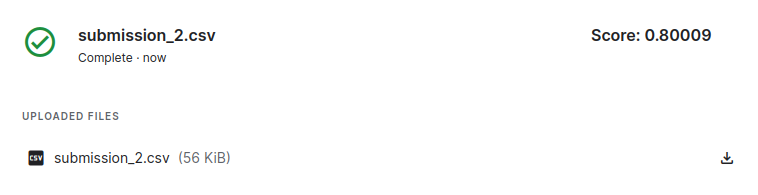

In [65]:
img_submission_2 = Image.open(REPORTS_DIR.joinpath('submission_2.png'))
display(img_submission_2)

## Задание №3 Blending (15 баллов)

Реализуйте блендинг(методом, представленном на лекции) с несколькими алгоритмами на ваш выбор. Продемонстрируйте качество вашей реализации: покажите метрики базовых моделей и ансамбля на тестовой выборке. Если в качестве метамодели вы используете логрег, выведите веса. Подбор гиперпараметров для ваших алгоритмов на ваше усмотрение. 

**Если вы смогли участвовать в Kaggle соревновании, приложите скриншот вашего сабмита с этим алгоритмом**

In [66]:
class Blending:
    def __init__(self, estimators, final_estimator, test_size=0.25, random_state=None):
        """
        estimators : list
            Список базовых моделей
        final_estimator:
            Метамодель для финального предсказания
        """
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.test_size = test_size
        self.random_state = random_state

    def __predict_proba_estimators(self, X):
        preds = []
        for estimator in self.estimators:
            preds.append(estimator.predict_proba(X))
        return np.array(preds)[:, :, 0].T
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        estimator_preds = np.zeros((X_test.shape[0], len(self.estimators)))

        for i, estimator in enumerate(self.estimators):
            estimator.fit(X_train, y_train)
            estimator_preds[:, i] = estimator.predict_proba(X_test)[:, 0]
        
        self.final_estimator.fit(estimator_preds, y_test)

    def predict_proba(self, X):
        estimator_preds = self.__predict_proba_estimators(X)
        return self.final_estimator.predict_proba(estimator_preds)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        return np.argmax(preds, axis=1)

In [67]:
estimators = [
    XGBClassifier(),
    LogisticRegression(),
    MultinomialNB(),
]

In [68]:
for estimator in tqdm(estimators):
    estimator.fit(X_train, y_train)

for estimator in estimators:
    print(f'{str(estimator)} test sample f1: {f1_score(y_test, estimator.predict(X_test)):.4f}')

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.88it/s]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) test sample f1: 0.8036
LogisticRegression() test sample f1: 0.7561
MultinomialNB() test sample f1: 0.7160


In [69]:
my_blending = Blending(estimators, LogisticRegression(max_iter=1000))
my_blending.fit(X, y)

print(f'My blending test sample f1: {f1_score(y_test, my_stacking.predict(X_test)):.4f}')

My blending test sample f1: 0.8682


In [70]:
print('Meta-model coeffs:\n')
for algorthm, coef in zip(estimators, my_blending.final_estimator.coef_[0]):
    print(f'{str(algorthm)}: {coef}')

Meta-model coeffs:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...): -4.117826343369121
LogisticRegression(): -1.6259726136758121
MultinomialNB(): 0.30297857115947024


### Submission

In [71]:
submission_3 = pd.DataFrame({
    'PassengerID': df_test['PassengerId'], 
    'Transported': my_blending.predict(X_submission).astype('bool')})

In [72]:
submission_3.to_csv(SUBMISSIONS_PATH.joinpath('submission_3.csv'), index=False)

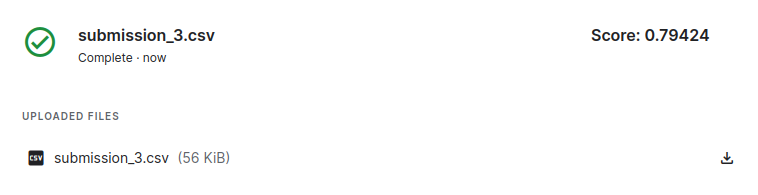

In [73]:
img_submission_3 = Image.open(REPORTS_DIR.joinpath('submission_3.png'))
display(img_submission_3)